<h1>Prepare Environment</h1>

In [43]:
from data_processing.Augmentation import *
from data_processing.helper import *

In [44]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
import time

<h1>Loading dataset</h1>

In [46]:
DATA_DIR = './CamVid/'

In [47]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [48]:
# Lets look at data we have
"""
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
"""
dataset = Dataset(x_train_dir, y_train_dir, 
                  classes = ['road', 'pavement', 'signsymbol','car', 
                             'pedestrian', 'bicyclist'])

image, mask = dataset[5] # get some sample

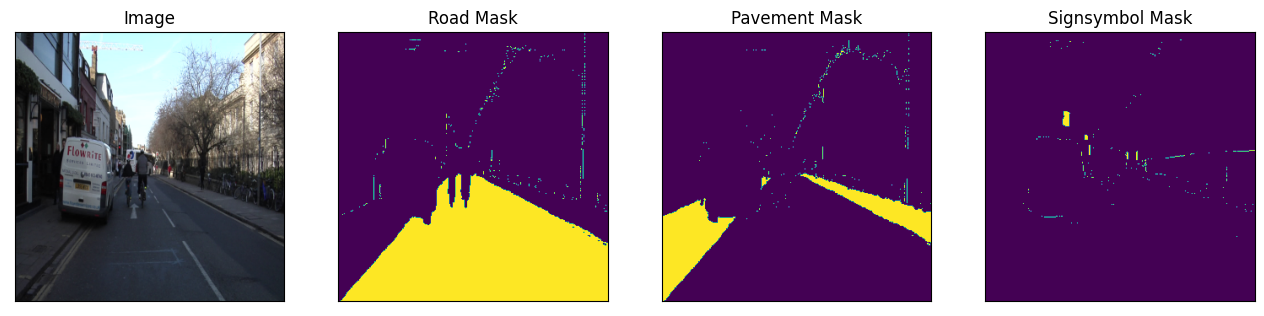

In [49]:
visualize(
    image=image, 
    road_mask=mask[..., 0].squeeze(),
    pavement_mask=mask[..., 1].squeeze(),
    signsymbol_mask=mask[..., 2].squeeze(),
)

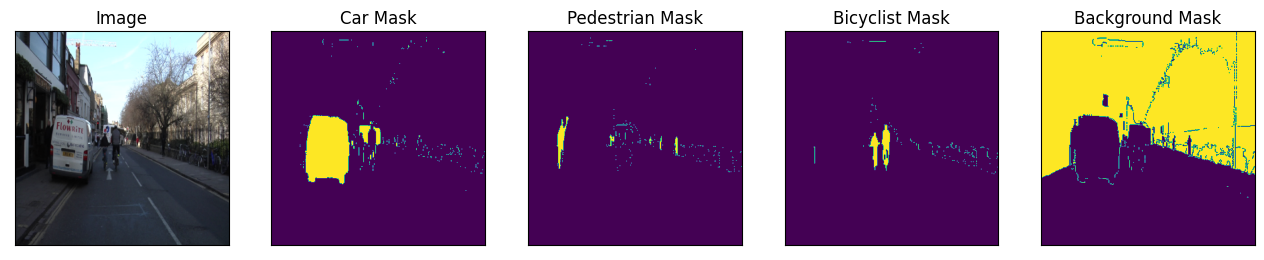

In [50]:
visualize(
    image=image, 
    car_mask=mask[..., 3].squeeze(),
    pedestrian_mask=mask[..., 4].squeeze(),
    bicyclist_mask=mask[..., 5].squeeze(),
    background_mask=mask[..., 6].squeeze(),
)

<h1>Augmentation</h1>

In [51]:
dataset = Dataset(x_train_dir, y_train_dir, 
                  classes = ['road', 'pavement', 'signsymbol','car', 
                             'pedestrian', 'bicyclist'], 
                  augmentation=get_training_augmentation())

In [52]:
image, mask = dataset[20] # get some sample

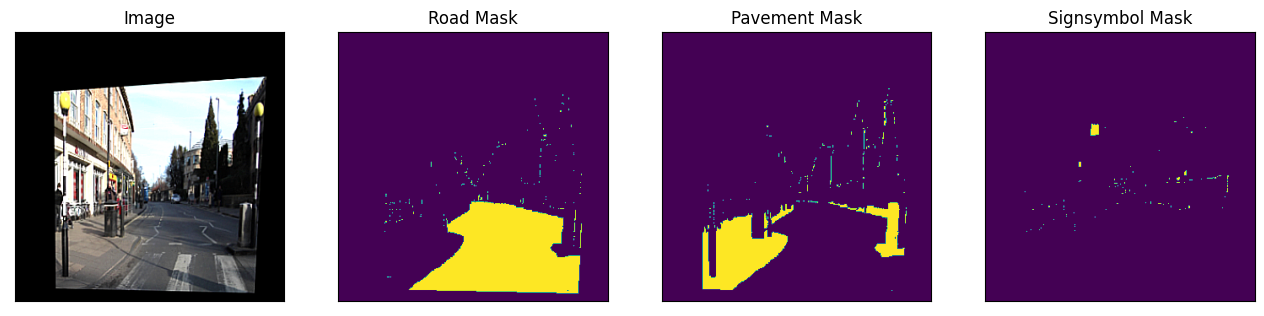

In [53]:
visualize(
    image=image, 
    road_mask=mask[..., 0].squeeze(),
    pavement_mask=mask[..., 1].squeeze(),
    signsymbol_mask=mask[..., 2].squeeze(),
)

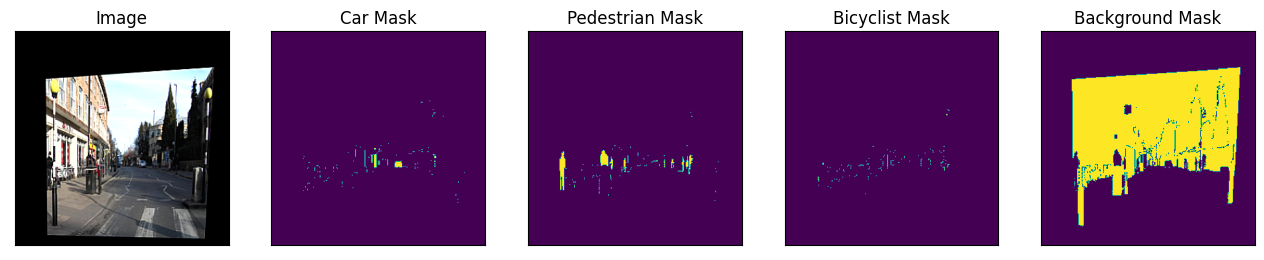

In [54]:
visualize(
    image=image, 
    car_mask=mask[..., 3].squeeze(),
    pedestrian_mask=mask[..., 4].squeeze(),
    bicyclist_mask=mask[..., 5].squeeze(),
    background_mask=mask[..., 6].squeeze(),
)

<h1>Segmentation Model Training</h1>

In [55]:
import segmentation_models as sm
sm.set_framework('tf.keras')

In [56]:
BACKBONE = 'vgg16'
BATCH_SIZE = 4
CLASSES = ['road', 'pavement', 'signsymbol','car', 'pedestrian', 'bicyclist']
LR = 0.0001

# Set number of epochs
EPOCHS = 250

# Patience for the learning rate
LR_PATIENCE = 5

# Patience for early stopping
STOPPING_PATIENCE = 30

preprocess_input = sm.get_preprocessing(BACKBONE)

In [57]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Linknet(BACKBONE, classes=n_classes, activation=activation)

In [58]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 3,4,5,6,0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, loss = total_loss, metrics = metrics)

In [59]:
model.summary(                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         )

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_3[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                                         

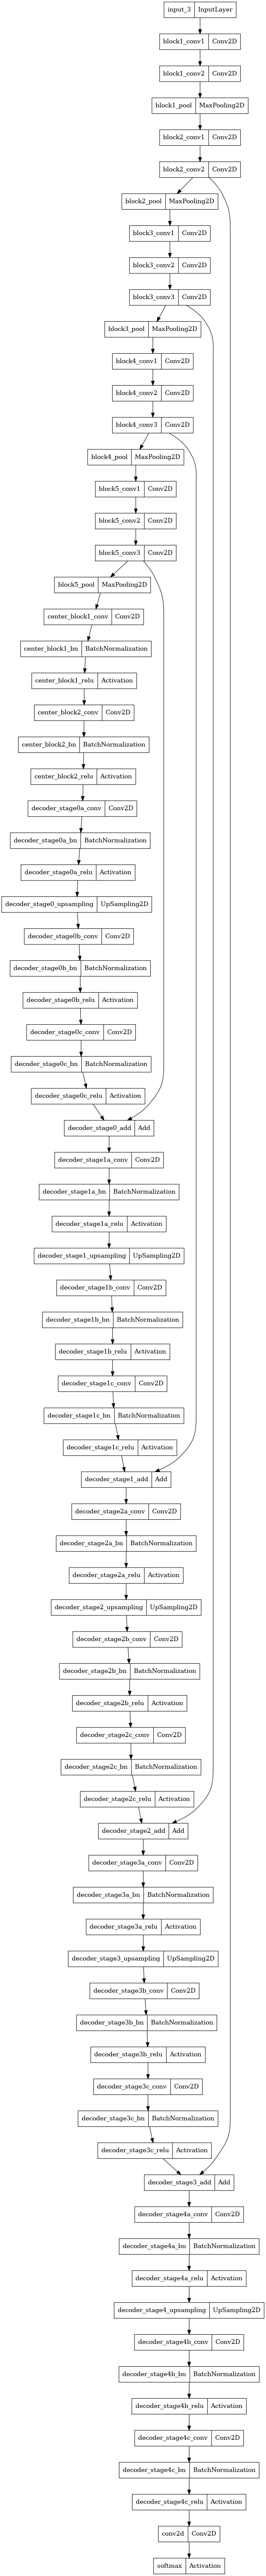

In [60]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [61]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

/home/waflol/anaconda3/envs/myenv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/waflol/anaconda3/envs/myenv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [62]:
from tensorflow.keras.callbacks import EarlyStopping
# define callbacks for learning rate scheduling and best checkpoints saving
checkpoint = tf.keras.callbacks.ModelCheckpoint('./checkpoint/vgg16_Linknet.h5', monitor='val_loss',save_weights_only=True, save_best_only=True, mode='min')
learning_rate = tf.keras.callbacks.ReduceLROnPlateau(patience=LR_PATIENCE, verbose=1, factor=0.5, min_delta=0.00001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=STOPPING_PATIENCE, verbose=1, restore_best_weights=True)


In [63]:
# train model
pre_train = time.time()
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=[learning_rate,early_stopping,checkpoint], 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)
time_training = time.time() - pre_train

/tmp/ipykernel_35334/1794659408.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/250
91/91 [==============================] - 39s 375ms/step - loss: 0.9005 - iou_score: 0.0658 - f1-score: 0.0969 - val_loss: 0.9189 - val_iou_score: 0.0442 - val_f1-score: 0.0720 - lr: 1.0000e-04
Epoch 2/250
91/91 [==============================] - 32s 352ms/step - loss: 0.8344 - iou_score: 0.1414 - f1-score: 0.1922 - val_loss: 0.8641 - val_iou_score: 0.1127 - val_f1-score: 0.1593 - lr: 1.0000e-04
Epoch 3/250
91/91 [==============================] - 32s 346ms/step - loss: 0.8048 - iou_score: 0.1791 - f1-score: 0.2353 - val_loss: 0.8719 - val_iou_score: 0.1303 - val_f1-score: 0.1838 - lr: 1.0000e-04
Epoch 4/250
91/91 [==============================] - 32s 356ms/step - loss: 0.7889 - iou_score: 0.1994 - f1-score: 0.2569 - val_loss: 0.7991 - val_iou_score: 0.1851 - val_f1-score: 0.2407 - lr: 1.0000e-04
Epoch 5/250
91/91 [==============================] - 33s 356ms/step - loss: 0.7754 - iou_score: 0.2109 - f1-score: 0.2697 - val_loss: 0.7864 - val_iou_score: 0.1874 - val_f1-score:

Epoch 41/250
91/91 [==============================] - 33s 358ms/step - loss: 0.4988 - iou_score: 0.4774 - f1-score: 0.5485 - val_loss: 0.4979 - val_iou_score: 0.4672 - val_f1-score: 0.5377 - lr: 1.0000e-04
Epoch 42/250
91/91 [==============================] - 32s 348ms/step - loss: 0.4952 - iou_score: 0.4799 - f1-score: 0.5516 - val_loss: 0.5097 - val_iou_score: 0.4616 - val_f1-score: 0.5371 - lr: 1.0000e-04
Epoch 43/250
91/91 [==============================] - 33s 359ms/step - loss: 0.4902 - iou_score: 0.4849 - f1-score: 0.5575 - val_loss: 0.4953 - val_iou_score: 0.4682 - val_f1-score: 0.5406 - lr: 1.0000e-04
Epoch 44/250
91/91 [==============================] - 33s 358ms/step - loss: 0.4958 - iou_score: 0.4790 - f1-score: 0.5538 - val_loss: 0.4920 - val_iou_score: 0.4841 - val_f1-score: 0.5696 - lr: 1.0000e-04
Epoch 45/250
91/91 [==============================] - 33s 357ms/step - loss: 0.4910 - iou_score: 0.4838 - f1-score: 0.5576 - val_loss: 0.4898 - val_iou_score: 0.4771 - val_f1-s

Epoch 79/250
91/91 [==============================] - 32s 349ms/step - loss: 0.4324 - iou_score: 0.5438 - f1-score: 0.6209 - val_loss: 0.4306 - val_iou_score: 0.5200 - val_f1-score: 0.6026 - lr: 2.5000e-05
Epoch 80/250
91/91 [==============================] - 32s 349ms/step - loss: 0.4250 - iou_score: 0.5510 - f1-score: 0.6301 - val_loss: 0.4365 - val_iou_score: 0.5190 - val_f1-score: 0.6017 - lr: 2.5000e-05
Epoch 81/250
91/91 [==============================] - 32s 349ms/step - loss: 0.4209 - iou_score: 0.5554 - f1-score: 0.6343 - val_loss: 0.4313 - val_iou_score: 0.5172 - val_f1-score: 0.6013 - lr: 2.5000e-05
Epoch 82/250
91/91 [==============================] - 33s 359ms/step - loss: 0.4334 - iou_score: 0.5430 - f1-score: 0.6227 - val_loss: 0.4159 - val_iou_score: 0.5293 - val_f1-score: 0.6164 - lr: 2.5000e-05
Epoch 83/250
91/91 [==============================] - 32s 349ms/step - loss: 0.4269 - iou_score: 0.5485 - f1-score: 0.6273 - val_loss: 0.4173 - val_iou_score: 0.5311 - val_f1-s

<h1>Model Evaluation</h1>

In [64]:
print('Time training:{} (s)'.format(time_training))

Time training:3602.7429869174957 (s)


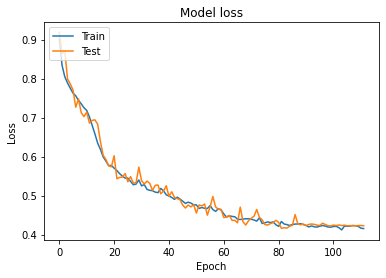

In [65]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

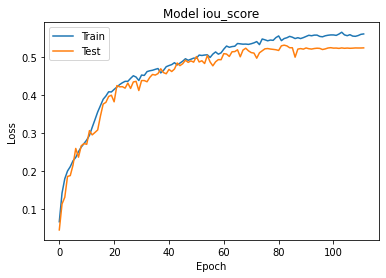

In [66]:
# Plot training & validation loss values
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [67]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [68]:
# load best weights
model.load_weights('./checkpoint/vgg16_Linknet.h5')

In [69]:
scores  = model.evaluate_generator(test_dataloader)
print("Loss:{:.5}".format(scores[0]))
for metric,value in zip(metrics,scores[1:]):
    print("mean {}:{:.5}".format(metric.__name__,value))

/tmp/ipykernel_35334/2477453485.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores  = model.evaluate_generator(test_dataloader)


Loss:0.48615
mean iou_score:0.49449
mean f1-score:0.56666


In [70]:
df = pd.DataFrame({'backbone':[BACKBONE],'model':['Linknet'],'Time_training':[time_training],
                   'loss':[scores[0]],'Iou_score':[scores[1]]})

In [71]:
df

,backbone,model,Time_training,loss,Iou_score
0,vgg16,Linknet,3602.742987,0.486155,0.494493


In [72]:
data = pd.read_excel('Evaluation_model.xlsx')
data = data[['backbone','model','Time_training','loss','Iou_score']]
data

,backbone,model,Time_training,loss,Iou_score
0,resnet50,FPN,5574.922504,0.429762,0.536333
1,vgg16,FPN,4756.101279,0.424975,0.544290
2,vgg16,Unet,4716.292528,0.450795,0.524129
3,resnet50,Unet,2754.380667,0.436002,0.532806
4,mobilenetv2,Unet,2111.109734,0.441323,0.526182
5,mobilenetv2,FPN,3336.091649,0.434233,0.532188
6,inceptionv3,FPN,4416.651027,0.433190,0.534531
7,efficientnetb3,Unet,3795.621106,0.429767,0.537205
8,efficientnetb3,FPN,5052.327916,0.428663,0.537585
9,inceptionv3,Unet,8913.769664,0.443069,0.527323


In [73]:
df = pd.concat([df,data],axis=0)
df

,backbone,model,Time_training,loss,Iou_score
0,vgg16,Linknet,3602.742987,0.486155,0.494493
0,resnet50,FPN,5574.922504,0.429762,0.536333
1,vgg16,FPN,4756.101279,0.424975,0.544290
2,vgg16,Unet,4716.292528,0.450795,0.524129
3,resnet50,Unet,2754.380667,0.436002,0.532806
4,mobilenetv2,Unet,2111.109734,0.441323,0.526182
5,mobilenetv2,FPN,3336.091649,0.434233,0.532188
6,inceptionv3,FPN,4416.651027,0.433190,0.534531
7,efficientnetb3,Unet,3795.621106,0.429767,0.537205
8,efficientnetb3,FPN,5052.327916,0.428663,0.537585


In [74]:
df.to_excel('Evaluation_model.xlsx')

<h1>Evaluation on Test</h1>

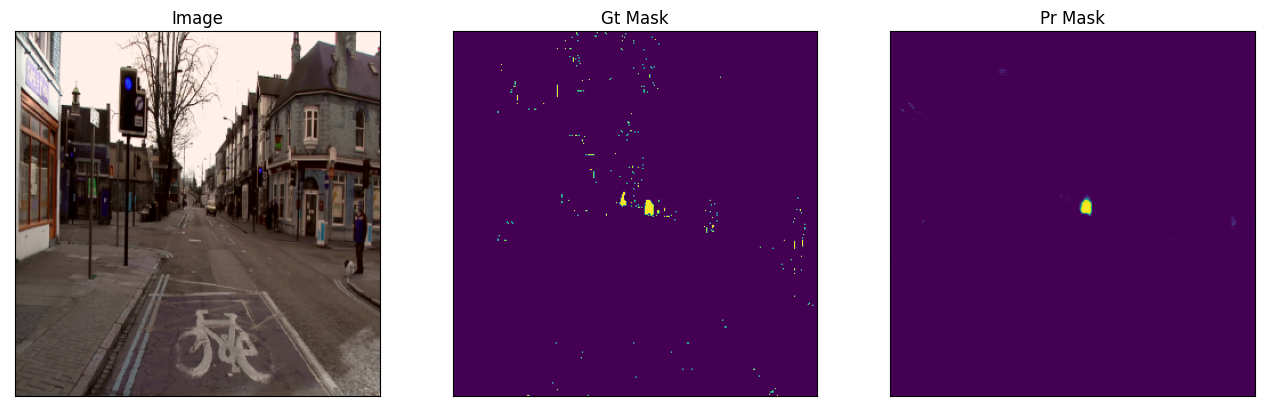

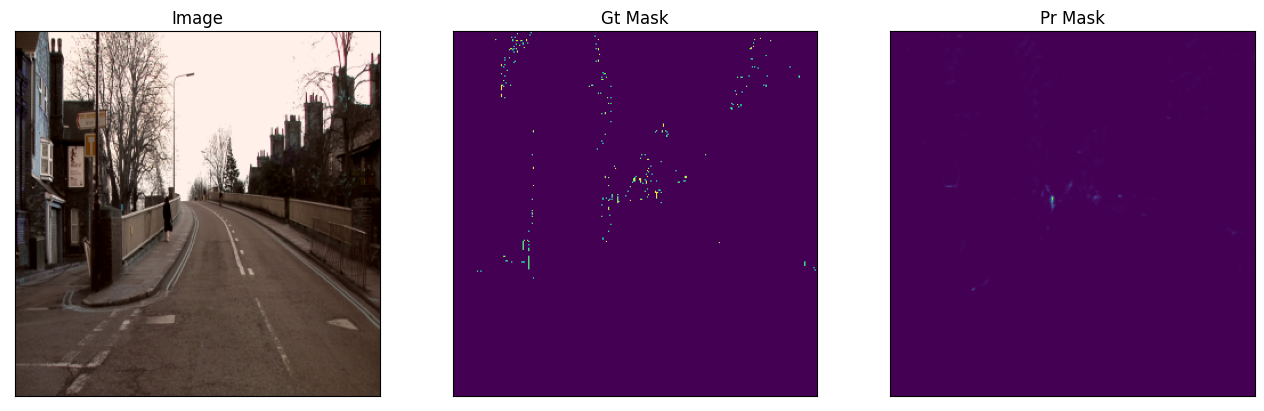

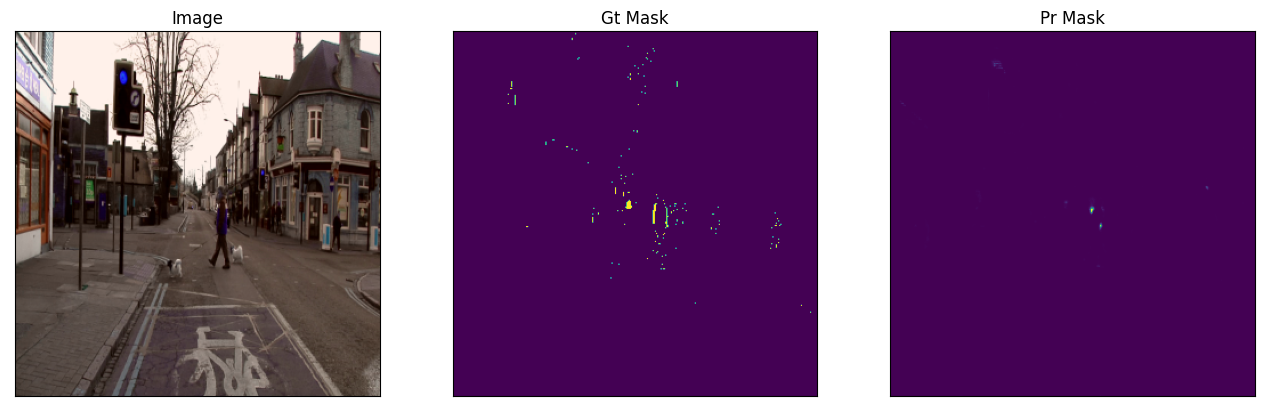

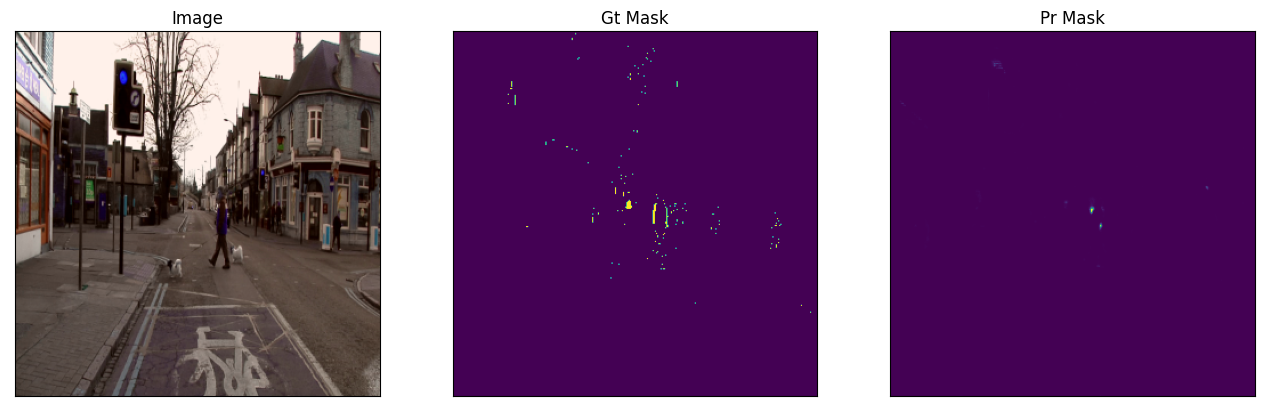

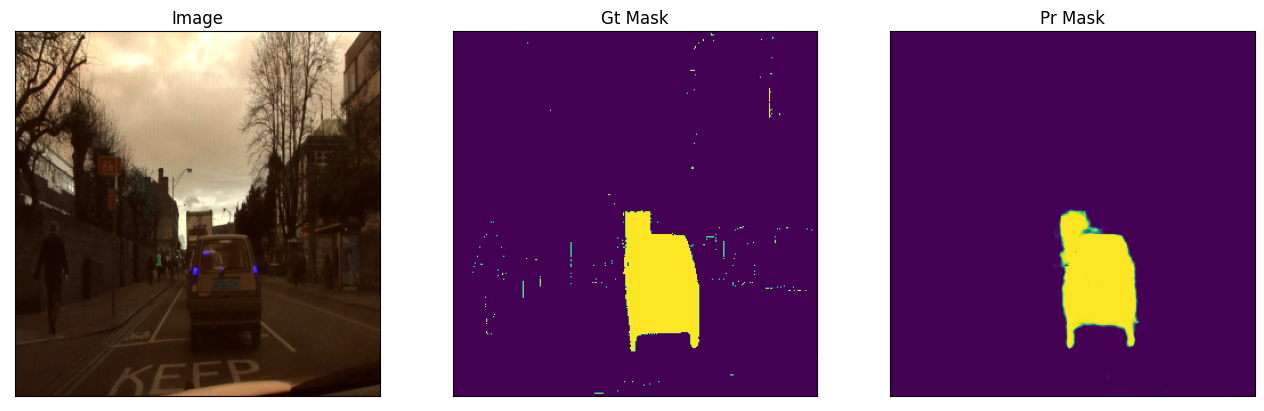

In [75]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[...,3].squeeze(),
        pr_mask=pr_mask[...,3].squeeze(),
    )